In [ ]:
!pip install transformers accelerate
!pip install vncorenlp
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=05d24701fec0b18a2a552b1e5152fa18e1dc8b0648c76fc4993e163195bc46a1
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2023-07-03 15:50:45--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   126MB/s    in 0.2s    

2023-07-03 15:50:45 (126 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2023-07-03 15:50:45--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
from google.colab import drive
import os
import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

In [ ]:
drive.mount('/gdrive')

In [ ]:
DIR_ROOT = '/gdrive/MyDrive/SpamReviewDetect'
DIR_DATASET = os.path.join(DIR_ROOT, 'dataset')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')

STOPWORDS_PATH = os.path.join(DIR_ROOT, 'vietnamese-stopwords-dash.txt')

MODEL_DIR = os.path.join(DIR_ROOT, 'transformer_model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


In [ ]:
labels_task_1 = ["no-spam", "spam"]
labels_task_2 = ["no-spam", "spam-1", "spam-2", "spam-3"]


def show_predict_result(trainer, test_dataset, y_test, labels):
    y_pred_classify = trainer.predict(test_dataset)
    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt='g',
                cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_data = pd.read_csv(PATH_TRAIN)
X_train = train_data.iloc[:, 0:2]
y_train = train_data.iloc[:, 2:4]

dev_data = pd.read_csv(PATH_DEV)
X_dev = dev_data.iloc[:, 0:2]
y_dev = dev_data.iloc[:, 2:4]

test_data = pd.read_csv(PATH_TEST)
X_test = test_data.iloc[:, 0:2]
y_test = test_data.iloc[:, 2:4]

In [ ]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar",
                      annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)


In [ ]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split()
                if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', text)


def preprocess(text, tokenized=True, lowercased=True):
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    text = filter_stop_words(text, stopwords)
    return text


def pre_process_features(X, y1, y2, tokenized=True, lowercased=True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased)
         for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y1, idx)
            np.delete(y2, idx)
    return X, y1, y2

In [ ]:
train_X, train_y, train_y_spam = pre_process_features(
    X_train['Comment'], y_train['Label'], y_train['SpamLabel'], tokenized=True, lowercased=False)
dev_X, dev_y, dev_y_spam = pre_process_features(
    X_dev['Comment'], y_dev['Label'], y_dev['SpamLabel'], tokenized=True, lowercased=False)
test_X, test_y, test_y_spam = pre_process_features(
    X_test['Comment'], y_test['Label'], y_test['SpamLabel'], tokenized=True, lowercased=False)


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
train_encodings = tokenizer(
    train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True,
                           padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

OUTPUT_DIR = os.path.join(MODEL_DIR, 'phobert', 'task_1')

training_args = TrainingArguments(
    output_dir="review_classfication_task1",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()
trainer.save_model(OUTPUT_DIR)

F1 - micro: 0.8940613990941118
F1 - macro: 0.8590318844755974
Accuracy: 0.8940613990941118


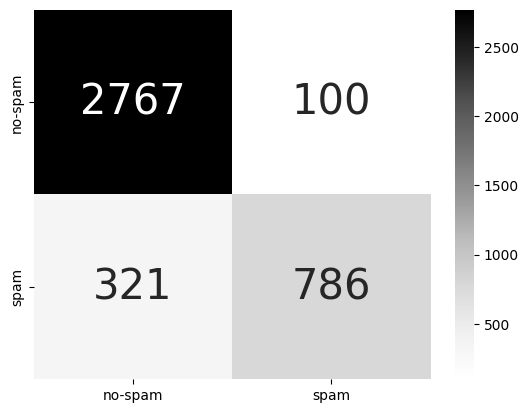

In [ ]:
show_predict_result(trainer, test_dataset, test_y, labels_task_1)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base", num_labels=4)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

In [ ]:
train_encodings = tokenizer(
    train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True,
                           padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y_spam)
dev_dataset = BuildDataset(dev_encodings, dev_y_spam)
test_dataset = BuildDataset(test_encodings, test_y_spam)

OUTPUT_DIR = os.path.join(MODEL_DIR, 'phobert', 'task_2')

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()
trainer.save_model(OUTPUT_DIR)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.606400
1000,0.403000
1500,0.308000


F1 - micro: 0.8917966784096629
F1 - macro: 0.7513607091935849
Accuracy: 0.8917966784096628


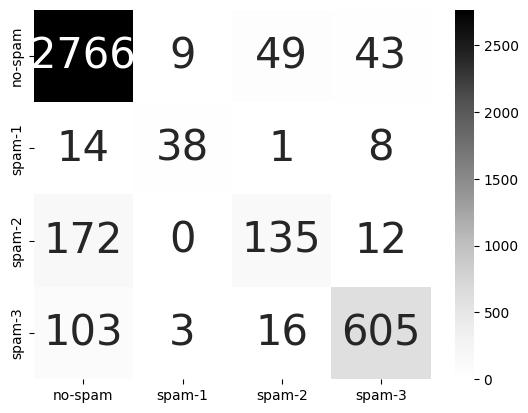

In [ ]:
show_predict_result(trainer, test_dataset, test_y_spam, labels_task_2)
